# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 66.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from scipy.stats import mode


from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4745,0,25.0,35500.0,2,0
4478,1,45.0,50600.0,1,1
4650,1,23.0,42000.0,0,0
2870,1,36.0,33500.0,2,0
1927,1,30.0,54900.0,1,0
4225,1,43.0,57000.0,1,1
3004,0,38.0,31500.0,1,0
343,0,25.0,54900.0,1,0
3914,1,39.0,32000.0,1,0
3534,1,39.0,30900.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:

df["age"] = df["age"].astype("Int64")


In [8]:
# cambiaremos el tipo de dato de income por entero tambien
df["income"] = df["income"].round()

df["income"] = df["income"].astype("Int64")


In [9]:
# comprueba que la conversión se haya realizado con éxito

print(df["age"])
df["income"]

0       41
1       46
2       29
3       21
4       28
        ..
4995    28
4996    34
4997    20
4998    22
4999    28
Name: age, Length: 5000, dtype: Int64


0       49600
1       38000
2       21000
3       41700
4       26100
        ...  
4995    35700
4996    52400
4997    33900
4998    32700
4999    40600
Name: income, Length: 5000, dtype: Int64

In [10]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

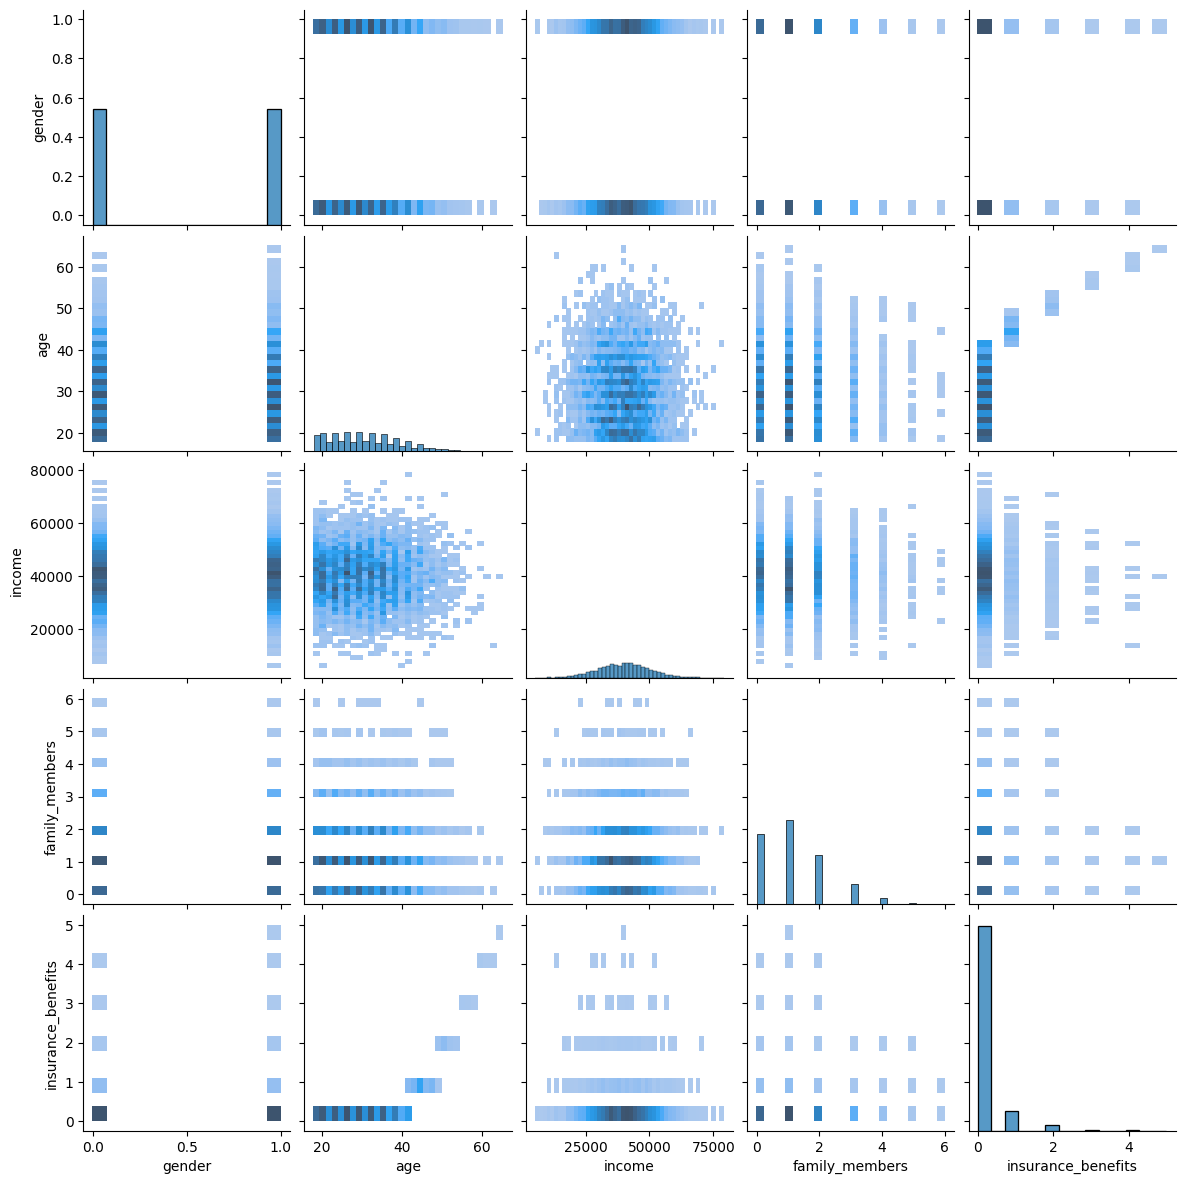

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1226,0.0,0.476923,0.375949,0.166667,0
2722,0.0,0.446154,0.534177,0.333333,0
4196,0.0,0.369231,0.427848,0.000000,0
2770,0.0,0.584615,0.431646,0.166667,0
577,0.0,0.476923,0.311392,0.333333,0


In [17]:
df_scaled.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,0.476197,0.505270,0.199033,0.148000
std,0.500049,0.129859,0.125318,0.181898,0.463183
min,0.000000,0.276923,0.067089,0.000000,0.000000
25%,0.000000,0.369231,0.421519,0.000000,0.000000
50%,0.000000,0.461538,0.508861,0.166667,0.000000
75%,1.000000,0.569231,0.589873,0.333333,0.000000
max,1.000000,1.000000,1.000000,1.000000,5.000000


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
n = 3972
k = 6
eu = get_knn(df, n, k, "euclidean")
eu

,gender,age,income,family_members,insurance_benefits,distance
3972,1,40,41000,1,0,0.000000
5,1,43,41000,2,1,3.162278
2717,0,37,41000,0,0,3.316625
3434,1,36,41000,2,0,4.123106
1740,0,36,41000,1,0,4.123106
1383,1,35,41000,0,0,5.099020


In [19]:
man = get_knn(df, n, k, "manhattan")
man

,gender,age,income,family_members,insurance_benefits,distance
3972,1,40,41000,1,0,0.0
5,1,43,41000,2,1,4.0
1740,0,36,41000,1,0,5.0
2717,0,37,41000,0,0,5.0
3434,1,36,41000,2,0,5.0
4763,1,46,41000,1,1,6.0


In [20]:
scal_eu = get_knn(df_scaled, n, k, "euclidean")
scal_eu

,gender,age,income,family_members,insurance_benefits,distance
3972,1.0,0.615385,0.518987,0.166667,0,0.000000
1641,1.0,0.615385,0.525316,0.166667,0,0.006329
2824,1.0,0.615385,0.530380,0.166667,0,0.011392
4590,1.0,0.615385,0.505063,0.166667,0,0.013924
1393,1.0,0.615385,0.503797,0.166667,0,0.015190
3720,1.0,0.600000,0.517722,0.166667,0,0.015437


In [21]:
scal_man = get_knn(df_scaled, n, k, "manhattan")
scal_man

,gender,age,income,family_members,insurance_benefits,distance
3972,1.0,0.615385,0.518987,0.166667,0,0.000000
1641,1.0,0.615385,0.525316,0.166667,0,0.006329
2824,1.0,0.615385,0.530380,0.166667,0,0.011392
4590,1.0,0.615385,0.505063,0.166667,0,0.013924
1393,1.0,0.615385,0.503797,0.166667,0,0.015190
3720,1.0,0.600000,0.517722,0.166667,0,0.016650


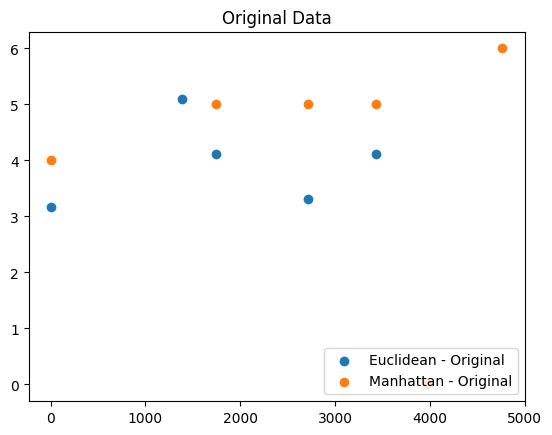

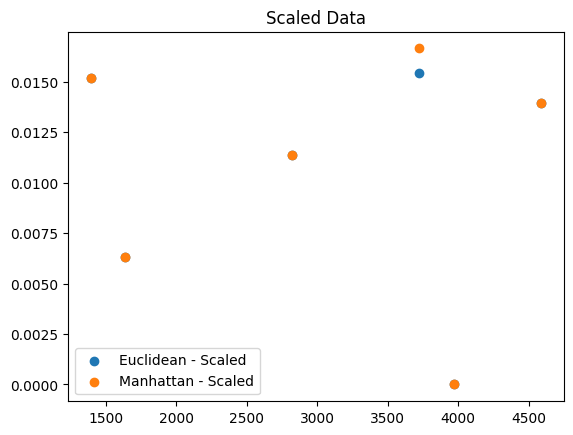

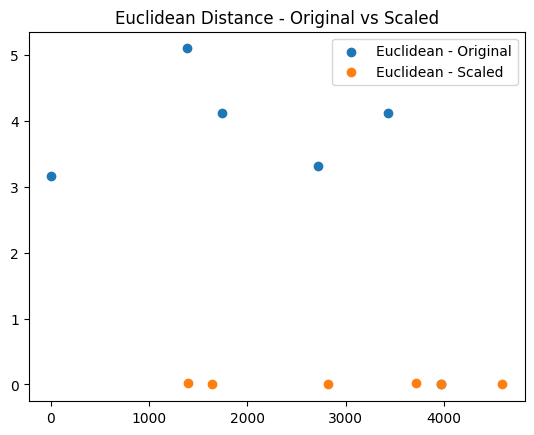

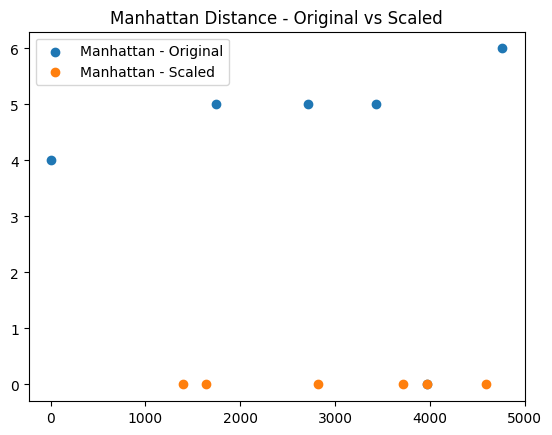

In [22]:
plt.scatter(eu.index, eu['distance'], label='Euclidean - Original')
plt.scatter(man.index, man['distance'], label='Manhattan - Original')
plt.title("Original Data")
plt.legend(loc = "lower right")
plt.show()

plt.scatter(scal_eu.index, scal_eu['distance'], label='Euclidean - Scaled')
plt.scatter(scal_man.index, scal_man['distance'], label='Manhattan - Scaled')
plt.title("Scaled Data")
plt.legend()
plt.show()

plt.scatter(eu.index, eu['distance'], label='Euclidean - Original')
plt.scatter(scal_eu.index, scal_eu['distance'], label='Euclidean - Scaled')
plt.title("Euclidean Distance - Original vs Scaled")
plt.legend()
plt.show()

plt.scatter(man.index, man['distance'], label='Manhattan - Original')
plt.scatter(scal_man.index, scal_man['distance'], label='Manhattan - Scaled')
plt.title("Manhattan Distance - Original vs Scaled")
plt.legend()
plt.show()


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si afecta, ya que cambian los rangos de las medias, cuando escalamos los datos estos se miden de una forma mas
pareja, haciendo que sea mas real cualquier filtro que se aplique.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

los datos son totalmente diferentes, no se asemejan, como podemos ver el grafico los puntos de los grupos se posicionan unos arriba y otros totalmente opuestos abajo, dejando ver la gran diferencia entre ellos.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [23]:
# сalcula el objetivo
# Calcular la probabilidad de recibir beneficios del seguro
df['insurance_benefits_received'] = (df["insurance_benefits"] > 0).astype(int)
df_scaled['insurance_benefits_received'] = (df_scaled["insurance_benefits"] > 0).astype(int)

In [24]:
df["insurance_benefits_received"]

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: insurance_benefits_received, Length: 5000, dtype: int64

In [25]:
# comprueba el desequilibrio de clases con value_counts()
df.value_counts()

gender  age  income  family_members  insurance_benefits  insurance_benefits_received
1       19   43200   1               0                   0                              3
0       21   37200   0               0                   0                              3
1       30   49900   1               0                   0                              3
0       28   39800   1               0                   0                              3
        31   49400   1               0                   0                              3
                                                                                       ..
        35   37400   0               0                   0                              1
             37100   0               0                   0                              1
             36200   1               0                   0                              1
             36100   2               0                   0                              1
1       65   39

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [27]:
#segmentacion de datos

features = df.drop(['insurance_benefits'], axis=1)
target = df['insurance_benefits']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.7, random_state=12345) 
#se segmenta el 70 % de los datos para hacer el conjunto de validación

In [28]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [29]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
   
    y_pred_rnd = rnd_model_predict(P, df.shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd) 
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [30]:
# Bucle para generar y evaluar las predicciones con datos originales y escalados
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'La probabilidad: {P:.2f}')
   
    # Predicciones con datos originales
    y_pred_rnd = rnd_model_predict(P, df.shape[0])
    print("Resultados con datos originales:")
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    # Predicciones con datos escalados
    y_pred_rnd_scaled = rnd_model_predict(P, df.shape[0])
    print("Resultados con datos escalados:")
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd_scaled)
    
    print()

La probabilidad: 0.00
Resultados con datos originales:
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]
Resultados con datos escalados:
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
Resultados con datos originales:
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]
Resultados con datos escalados:
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
Resultados con datos originales:
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]
Resultados con datos escalados:
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
Resultados con datos originales:
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]
Resultados con datos escalados:
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



El modelo aleatorio que implemente genera predicciones de manera aleatoria basadas en una probabilidad fija P. Estas predicciones no están influenciadas por los valores específicos de los datos, ya que el modelo aleatorio no aprende de los datos de entrenamiento.

Cuando utilicé este modelo para generar predicciones con datos originales y escalados, el resultado fue el mismo para ambos conjuntos de datos porque el modelo no está realmente procesando los datos ni aprendiendo de ellos. Simplemente está aplicando una regla aleatoria basada en la probabilidad P.

Es por eso que ves resultados idénticos cuando utilizo el modelo aleatorio con datos originales y escalados.

In [31]:
def knn_model_predict(df, k, metric, feature_names, target_column):
    """
    Devuelve las etiquetas de clase de los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia
    :param feature_names: lista de nombres de características (features) a utilizar
    :param target_column: nombre de la columna que contiene las etiquetas de clase
    """
    predictions = []
    for n in range(len(df)):
        # Instanciar el modelo NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
        # Ajustar el modelo
        nbrs.fit(df[feature_names])
        # Encontrar los índices de los k vecinos más cercanos y sus distancias
        nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=False)[0]
        # Obtener las etiquetas de clase de los vecinos más cercanos
        neighbors_labels = df.iloc[nbrs_indices][target_column].values
        # Tomar la moda de las etiquetas de clase de los vecinos más cercanos
        predicted_label = mode(neighbors_labels)[0][0]
        predictions.append(predicted_label)
    return predictions


In [32]:
# Iterar sobre las probabilidades
# Probabilidades a evaluar
probabilidades = [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]

# Iterar sobre las probabilidades
for P in probabilidades:
    print(f'Probabilidad: {P:.2f}')

    # Predicciones con modelo aleatorio y datos originales
    y_pred_rnd = rnd_model_predict(P, df.shape[0])
    print("Resultados del modelo aleatorio con datos originales:")
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

    # Predicciones con modelo aleatorio y datos escalados (iguales)
    y_pred_rnd_scaled = rnd_model_predict(P, df.shape[0])  # Usando df.shape[0]
    print("Resultados del modelo aleatorio con datos escalados:")
    eval_classifier(df_scaled['insurance_benefits_received'], y_pred_rnd_scaled)

    # Predicciones con modelo KNN y datos originales
    y_pred_knn_normal = knn_model_predict(df, 5, 'euclidean', ['gender', 'age', 'income', 'family_members'], 'insurance_benefits_received')
    print("Resultados del modelo KNN con datos originales:")
    eval_classifier(df['insurance_benefits_received'], y_pred_knn_normal)

    # Predicciones con modelo KNN y datos escalados
    y_pred_knn_scaled = knn_model_predict(df_scaled, 5, 'euclidean', ['gender', 'age', 'income', 'family_members'], 'insurance_benefits_received')
    print("Resultados del modelo KNN con datos escalados:")
    eval_classifier(df_scaled['insurance_benefits_received'], y_pred_knn_scaled)

    print()


Probabilidad: 0.00
Resultados del modelo aleatorio con datos originales:
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]
Resultados del modelo aleatorio con datos escalados:
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]
Resultados del modelo KNN con datos originales:
F1: 0.57
Matriz de confusión
[[0.8844 0.0028]
 [0.0672 0.0456]]
Resultados del modelo KNN con datos escalados:
F1: 0.97
Matriz de confusión
[[8.868e-01 4.000e-04]
 [5.600e-03 1.072e-01]]

Probabilidad: 0.11
Resultados del modelo aleatorio con datos originales:
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]
Resultados del modelo aleatorio con datos escalados:
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]
Resultados del modelo KNN con datos originales:
F1: 0.57
Matriz de confusión
[[0.8844 0.0028]
 [0.0672 0.0456]]
Resultados del modelo KNN con datos escalados:
F1: 0.97
Matriz de confusión
[[8.868e-01 4.000e-04]
 [5.600e-03 1.072e-01]]

Probabilidad: 0.50
R

In [33]:
# Lista de nombres de modelos
modelos = ['Modelo Aleatorio (Original)', 'Modelo Aleatorio (Escalado)', 'KNN (Original)', 'KNN (Escalado)']

# Lista de puntuaciones F1 para cada modelo
f1_scores = [f1_score_random_original, f1_score_random_scaled, f1_score_knn_original, f1_score_knn_scaled]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, f1_scores, color=['blue', 'orange', 'green', 'red'])

# Añadir etiquetas y título
plt.xlabel('Modelo')
plt.ylabel('F1-score')
plt.title('Comparación de F1-score entre modelos')
plt.ylim(0, 1)  # Ajustar límites en el eje y para una mejor visualización

# Mostrar gráfico
plt.show()



NameError: name 'f1_score_random_original' is not defined

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

X_train = X_train.astype(float)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [37]:
#datos escalados
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

X_train = X_train.astype(float)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [40]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [41]:
try:
    # Intentar calcular la inversa de la matriz P
    inv_P = np.linalg.inv(P)
    print("La matriz P es invertible.")
except np.linalg.LinAlgError:
    print("La matriz P no es invertible.")
    
print(inv_P)

La matriz P es invertible.
[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [42]:
ofus = X @ P
ofus

array([[6359.715273139105, 22380.40467609026, 18424.09074183637,
        46000.69669015785],
       [4873.294064793656, 17160.367029820114, 14125.780761328471,
        35253.45577301139],
       [2693.117429275205, 9486.397744004375, 7808.831560241926,
        19484.86063067367],
       ...,
       [4346.22342489892, 15289.241264919003, 12586.162643921967,
        31433.50888551671],
       [4194.093241552677, 14751.991024200619, 12144.029306365586,
        30323.887634259787],
       [5205.468273536653, 18314.248144458878, 15077.013707617267,
        37649.59295455183]], dtype=object)

Miramos los datos nuevos y no tienen nada parecido al df inicial ni se entienden a que pertenece cada numero

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [43]:
recovered = ofus @ inv_P
recovered

array([[0.999999999992724, 40.99999999999636, 49599.99999999999,
        1.000000000005457],
       [-5.002220859751105e-12, 46.0, 37999.999999999985,
        1.0000000000027285],
       [-3.637978807091713e-12, 28.99999999999818, 20999.999999999996,
        -9.094947017729282e-13],
       ...,
       [9.094947017729282e-13, 20.0, 33899.99999999999,
        2.000000000003638],
       [0.9999999999918145, 21.999999999996362, 32700.0,
        3.0000000000059117],
       [0.9999999999954525, 27.999999999996362, 40599.99999999999,
        1.0000000000027285]], dtype=object)

In [44]:
X

array([[1, 41, 49600, 1],
       [0, 46, 38000, 1],
       [0, 29, 21000, 0],
       ...,
       [0, 20, 33900, 2],
       [1, 22, 32700, 3],
       [1, 28, 40600, 1]], dtype=object)

Si se pueden recuperar los datos de esa manera.

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [45]:
for i in range(3):
    print("\nclient: ", i+1)
    print("Datos Originales", X[i, :])
    print("Datos Transformados", ofus[i, :])
    print("Invertido", recovered[i, :])


client:  1
Datos Originales [1 41 49600 1]
Datos Transformados [6359.715273139105 22380.40467609026 18424.09074183637 46000.69669015785]
Invertido [0.999999999992724 40.99999999999636 49599.99999999999 1.000000000005457]

client:  2
Datos Originales [0 46 38000 1]
Datos Transformados [4873.294064793656 17160.367029820114 14125.780761328471 35253.45577301139]
Invertido [-5.002220859751105e-12 46.0 37999.999999999985 1.0000000000027285]

client:  3
Datos Originales [0 29 21000 0]
Datos Transformados [2693.117429275205 9486.397744004375 7808.831560241926 19484.86063067367]
Invertido [-3.637978807091713e-12 28.99999999999818 20999.999999999996
 -9.094947017729282e-13]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Esto es porque se expresan en notacion cientifica

La precisión numérica finita es un concepto fundamental en informática y matemáticas computacionales. Se refiere a la limitación de la cantidad de dígitos que pueden ser representados y manipulados en un sistema computacional. Esta limitación puede conducir a errores de redondeo y otros problemas cuando se realizan operaciones matemáticas.

En la mayoría de los sistemas computacionales, los números se representan utilizando un formato finito, como los números de punto flotante. En estos formatos, solo se pueden representar un número limitado de dígitos significativos, lo que significa que algunos números no pueden ser representados con precisión exacta. Por ejemplo, en un sistema de precisión finita, 1/3 no se puede representar exactamente como un número de punto flotante.

Los errores de precisión numérica finita pueden acumularse y afectar la exactitud de los cálculos, especialmente en operaciones iterativas o en cálculos que implican números muy grandes o muy pequeños. Los algoritmos y técnicas numéricas se desarrollan para minimizar estos errores y garantizar que los cálculos se realicen con la mayor precisión posible dentro de las limitaciones del sistema.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

Para responder a esta pregunta, podemos utilizar una propiedad relacionada con la inversa de una matriz y la transposición del producto de matrices. La propiedad que nos será útil en este caso es:

Reversibilidad de la transposición de un producto de matrices:
$(AB)^T = B^TA^T$

Ya que tenemos la formula para los pesos originales y para los nuevos pesos, podemos sustituir
$Xp = X.P$ para simplificar los nuevos pesos.

Donde $Wp = [(X.P)^T(X.P)]^-1(X.P)^Ty$

Utilizando la propiedad de reversibilidad de la transposición de un producto de matrices, tenemos:

$(AB)^T = B^TA^T$ Entonces

$(XP)^T = P^TX^T$

$wp = (P^TX^TXP)^-1P^TX^Ty$

$wp = (P^T(X^TXP))^-1P^TX^Ty$

$(AB)^{-1} = B^{-1}A^{-1}$

$(P^T(X^TXP))^-1 = (X^TXP)^-1(P^T)^-1$

$wp = (X^TXP)^-1(P^T)^-1P^TX^Ty$

$wp = ((X^TX)P)^-1(P^T)^-1P^TX^Ty$

$(X^TXP)^-1 = P^-1(X^TX)^-1$ 

$wp = P^-1(X^TX)^-1(P^T)^-1P^TX^Ty$

$(P^T)^-1P^T = I$

$wp = P^-1(X^TX)^-1IX^Ty$

$wp = P^-1(X^TX)^-1X^Ty$

$wp = P^-1w$

¿Cuáles serían los valores predichos con $w_P$? 

$yp =X⋅P⋅wp$

$yp =X⋅PP^-1w$

$yp =X⋅Iw$

$yp =Xw$

Entonces 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

Dado que los valores predichos con $w$ y $wp$ son los mismos, la calidad de la regresión lineal medida mediante el RECM no se ve afectada por la ofuscación de datos. Esto significa que, aunque los datos estén ofuscados, el modelo de regresión lineal seguirá produciendo predicciones precisas como lo haría con los datos originales.

En resumen, la ofuscación de datos no afecta la calidad de la regresión lineal medida mediante RECM, lo que demuestra que la regresión lineal es inmune a la transformación lineal de los datos.

**Prueba analítica**

$yp =Xw$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [46]:
#generar una matriz aleatoria
rng_1 = np.random.default_rng(seed=42)
P_1 = rng.random(size=(X.shape[1], X.shape[1]))

In [47]:
#comprobamos que sea invertible
try:
    # Intentar calcular la inversa de la matriz P_1
    inv_P_1 = np.linalg.inv(P_1)
    print("La matriz P_1 es invertible.")
except np.linalg.LinAlgError:
    print("La matriz P_1 no es invertible.")
    
print(inv_P_1)

La matriz P_1 es invertible.
[[-3.30407744  4.40917525 -0.27870525 -1.90039547]
 [-0.95858897 -1.33121709  1.62644533  1.78106755]
 [ 6.24868421 -7.35167522  2.19103126  2.60761164]
 [-3.6064091   5.89580272 -2.79039845 -1.92803822]]


In [48]:
#ofuscamiento de datos
of = X @ P_1
of

array([[38639.61192648117, 9669.362340360263, 23190.732797188986,
        2210.883923152314],
       [29613.599214338945, 7413.262141861984, 17780.79501290537,
        1706.5941812279489],
       [16368.037983011474, 4097.694117967086, 9829.29132097517,
        945.779594050148],
       ...,
       [26402.67088458637, 6606.708813450784, 15842.745511146173,
        1504.745102078368],
       [25470.835737857113, 6374.598282174029, 15286.194096050422,
        1455.565999507894],
       [31624.305312196204, 7913.005132106867, 18977.624689328546,
        1805.039456490066]], dtype=object)

In [49]:
#nuevo split

x_train_of, x_test_of, _, _ = train_test_split(of, y, test_size=0.3, random_state=12345)

In [50]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


In [51]:
x_train_of = x_train_of.astype(float)

lr_of = MyLinearRegression()

lr_of.fit(x_train_of, y_train)
print(lr_of.weights)

y_test_pred_of = lr_of.predict(x_test_of)
eval_regressor(y_test, y_test_pred_of)

[-0.94354071  0.12556581 -0.08415868 -0.1906556   0.17406945]
RMSE: 0.34
R2: 0.66


# Conclusiones

En conclusion podemos decir que el modelo lineal puede funcionar correctamente tanto con los datos normales y con los datos ofuscados. 
Sin alterar las predicciones, permitiendo que los datos de los usuarios sean protegidos y a la vez dejar que trabaje de forma adecuada el modelo de prediccion.
Utilizamos las medidas RMSE y R2 para medir a los dos resultados de los modelos y estos fueron exactamente iguales, demostrando que nuestra teoria es cierta.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  Se ha realizado la tarea 1
    - [x]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [ ]  Se respondieron las preguntas sobre la escala/distancia- [ ]  Se ha realizado la tarea 2
    - [x]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [ ]  Se ha realizado la tarea 3
    - [x]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [ ]  Se calculó la RECM para la solución implementada- [ ]  Se ha realizado la tarea 4
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>